### **CS6501 - MACHINE LEARNING AND APPLICATIONS**
#### **NOTEBOOK-1 : Data Preprocessing**

#### --- Library Imports ---

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
import seaborn as sns
import numpy as np

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)
colors = {
    'numerical': '#1f77b4',   
    'categorical': '#ff7f0e', 
    'missing': '#2ca02c',     
    'duplicates': '#d62728' 
}
sns.set_palette(list(colors.values()))

#### --- Dataset Loading and Initial Exploration ---

In [3]:
# filepath of RAW dataset from SEAI
file_path = r"..\dataset\BERPublicsearch.csv"
# load the dataset as dataframe
df = pd.read_csv(file_path)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [4]:
# row and column counts
num_rows, num_cols = df.shape
print(f"Raw dataset shape: {num_rows:,} rows × {num_cols:,} columns")

Raw dataset shape: 1,048,575 rows × 211 columns


In [5]:
# count of numerical and categorical columns
num_numeric = df.select_dtypes(include=['number']).shape[1]
num_categorical = df.select_dtypes(include=['object', 'category']).shape[1]
print(f"Numerical columns count: {num_numeric}")
print(f"Categorical column count: {num_categorical}")

Numerical columns count: 157
Categorical column count: 54


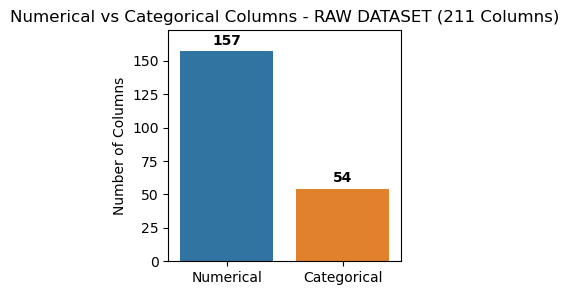

In [6]:
# bar plot to depict count distribution
plt.figure(figsize=(3,3))
ax = sns.barplot(
    x=['Numerical', 'Categorical'],
    y=[num_numeric, num_categorical],
    palette=[colors['numerical'], colors['categorical']]
)
for i, v in enumerate([num_numeric, num_categorical]):
    ax.text(i, v + 5, str(v), color='black', ha='center', fontweight='bold')
plt.ylabel('Number of Columns')
plt.title('Numerical vs Categorical Columns - RAW DATASET (211 Columns)')
plt.ylim(0, max(num_numeric, num_categorical)*1.1)
plt.show()

#### --- Dropping Columns With High Missing Values ---
Columns with more than 50% missing values are removed to ensure data quality and reduce noise in the modeling process.

In [7]:
# compute missing percentage for each column
missing_percent = (df.isna().sum() / len(df)) * 100
total_cols = df.shape[1]
num_missing_cols = (missing_percent > 0).sum()
print(f"Total columns: {total_cols}")
print(f"Columns with missing values: {num_missing_cols}")
print(f"Columns with no missing values: {total_cols - num_missing_cols}")

Total columns: 211
Columns with missing values: 157
Columns with no missing values: 54


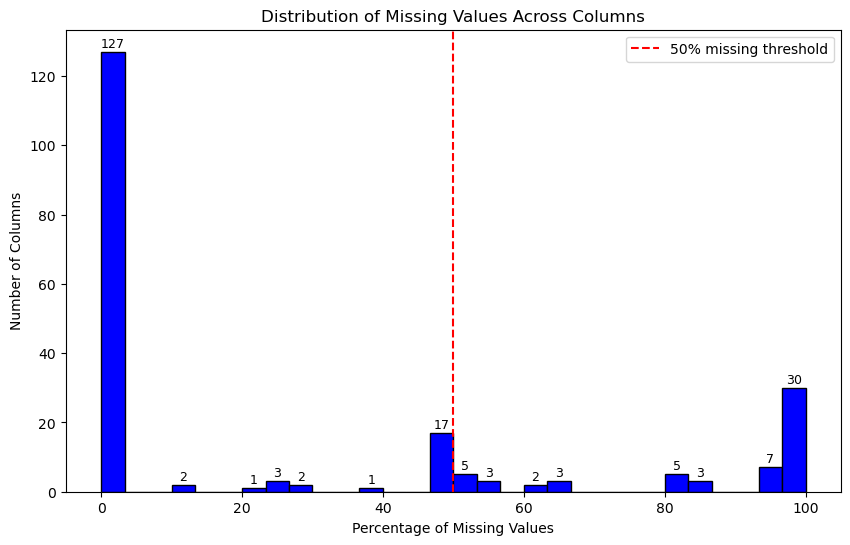

In [8]:
# plot distribution
plt.figure(figsize=(10,6))
counts, bins, patches = plt.hist(missing_percent, bins=30, color='blue', edgecolor='black')

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = counts[i]
    if y > 0:
        plt.text(x, y+0.5, int(y), ha='center', va='bottom', fontsize=9)
# threshold line for dropping columns
threshold = 50
plt.axvline(x=threshold, color='red', linestyle='--', label=f'{threshold}% missing threshold')
plt.title('Distribution of Missing Values Across Columns')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.legend()
plt.show()

In [9]:
# drop the columns
threshold = 50 
cols_to_drop = missing_percent[missing_percent > threshold].sort_values(ascending=False).index.tolist()
df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with more than {threshold}% missing values.")

Dropped 58 columns with more than 50% missing values.


In [10]:
print(f"AFTER DROPPING >50% EMPTY COLUMNS --- Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

AFTER DROPPING >50% EMPTY COLUMNS --- Dataset shape: 1048575 rows × 153 columns


#### --- Removing Duplicate Rows ---
Duplicate rows are removed to avoid biasing the model and inflating the dataset unnecessarily.

In [11]:
# identify duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows : {duplicates}")

Number of duplicate rows : 23256


In [12]:
# drop duplicated
df = df.drop_duplicates()
print(f"Duplicates removed")

Duplicates removed


In [13]:
print(f"AFTER DROPPING DUPLICATE ROWS --- Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

AFTER DROPPING DUPLICATE ROWS --- Dataset shape: 1025319 rows × 153 columns


#### --- Removing Rows with Invalid BER Ratings ---
Rows with BER ratings less than 0 are invalid and removed to ensure a meaningful target for prediction.

In [14]:
# identify negative BerRating rows
num_negative = (df['BerRating'] < 0).sum()
print(f"Number of rows with negative BER_Rating: {num_negative}")

Number of rows with negative BER_Rating: 3032


In [15]:
# drop negative BER value rows
df = df[df['BerRating'] >= 0]
print(f"Negative BER rating rows removed")

Negative BER rating rows removed


In [16]:
print(f"AFTER DROPPING NEGATIVE BER RATING ROWS --- Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

AFTER DROPPING NEGATIVE BER RATING ROWS --- Dataset shape: 1022287 rows × 153 columns


#### --- Stratified Sampling Based on BER Rating ---
The dataset is stratified into 10 bins based on the `BerRating` column to ensure proportional representation of all BER ranges in the sampled data. A sample of 80,000 rows is drawn using stratified sampling to maintain the original BER distribution while reducing computational complexity.

In [17]:
num_bins = 10
df['BER_bin'] = pd.qcut(df['BerRating'], q=num_bins, duplicates='drop')
# sample 80,000 rows stratified by BER bins
sample_size = 80_000
df_sample, _ = train_test_split(
    df,
    train_size=sample_size,
    stratify=df['BER_bin'],
    random_state=42
)
# compute counts per bin
bin_counts_full = df['BER_bin'].value_counts().sort_index()
bin_counts_sample = df_sample['BER_bin'].value_counts().sort_index()
# prepare comparison table
comparison_counts = pd.DataFrame({
    'BER Bin': bin_counts_full.index.astype(str),
    'Full Dataset': bin_counts_full.values,
    'Sampled Dataset': bin_counts_sample.values
}).reset_index(drop=True)

print("Stratified sampling complete (80k rows).")
display(comparison_counts)

Stratified sampling complete (80k rows).


,BER Bin,Full Dataset,Sampled Dataset
0,"(-0.001, 44.32]",102265,8003
1,"(44.32, 78.37]",102195,7997
2,"(78.37, 135.04]",102264,8003
3,"(135.04, 162.04]",102213,7999
4,"(162.04, 185.58]",102217,7999
5,"(185.58, 210.22]",102227,8000
6,"(210.22, 240.18]",102233,8000
7,"(240.18, 284.92]",102235,8000
8,"(284.92, 368.77]",102210,7999
9,"(368.77, 56423.71]",102228,8000


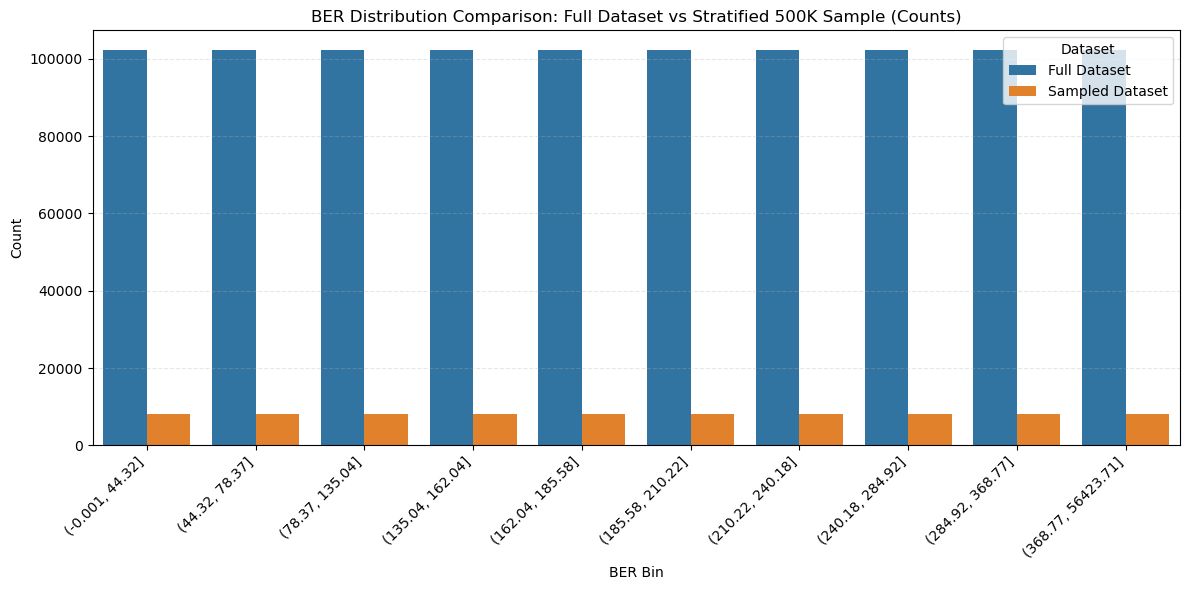

In [18]:
# melt dataframe for seaborn
plot_data = comparison_counts.melt(id_vars='BER Bin', var_name='Dataset', value_name='Count')

# side-by-side bar plot
plt.figure(figsize=(12,6))
sns.barplot(data=plot_data, x='BER Bin', y='Count', hue='Dataset', palette=['#1f77b4', '#ff7f0e'])
plt.xticks(rotation=45, ha='right')
plt.title('BER Distribution Comparison: Full Dataset vs Stratified 500K Sample (Counts)')
plt.xlabel('BER Bin')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

#### --- Numerical Missing Value Imputation ---

Missing numerical values are imputed using Iterative Imputer with a LightGBM regressor.
This approach predicts missing values using other numerical features, capturing non-linear relationships and preserving the overall data distribution.

In [19]:
# identify numeric columns
num_cols = df_sample.select_dtypes(include=['number']).columns.tolist()
# total numeric cells
total_numeric_cells = df_sample[num_cols].size
# total missing numeric cells
missing_numeric = df_sample[num_cols].isna().sum().sum()
# percentage missing
missing_pct = (missing_numeric / total_numeric_cells) * 100
print(f"Total numeric data points: {total_numeric_cells}")
print(f"Missing numeric data points: {missing_numeric}")
print(f"Percentage missing (numeric): {missing_pct:.2f}%")

Total numeric data points: 9040000
Missing numeric data points: 506804
Percentage missing (numeric): 5.61%


In [20]:
# LightGBM regressor
est = LGBMRegressor(n_estimators=50, num_leaves=31, learning_rate=0.05, verbose=-1)
# iterative imputer
imp = IterativeImputer(estimator=est, max_iter=3, initial_strategy='median', random_state=42)

print("starting model-based imputation:")
for i, col in enumerate(num_cols):
    print(f"Working on column {i+1}/{len(num_cols)}: {col}")
df_sample[num_cols] = imp.fit_transform(df_sample[num_cols])
print("Numerical Columns Imputation Completed.")

starting model-based imputation:
Working on column 1/113: Year_of_Construction
Working on column 2/113: BerRating
Working on column 3/113: GroundFloorArea(sq m)
Working on column 4/113: UValueWall
Working on column 5/113: UValueRoof
Working on column 6/113: UValueFloor
Working on column 7/113: UValueWindow
Working on column 8/113: UvalueDoor
Working on column 9/113: WallArea
Working on column 10/113: RoofArea
Working on column 11/113: FloorArea
Working on column 12/113: WindowArea
Working on column 13/113: DoorArea
Working on column 14/113: NoStoreys
Working on column 15/113: CO2Rating
Working on column 16/113: HSMainSystemEfficiency
Working on column 17/113: TGDLEdition
Working on column 18/113: MPCDERValue
Working on column 19/113: HSEffAdjFactor
Working on column 20/113: HSSupplHeatFraction
Working on column 21/113: HSSupplSystemEff
Working on column 22/113: WHMainSystemEff
Working on column 23/113: WHEffAdjFactor
Working on column 24/113: SupplSHFuel
Working on column 25/113: Suppl

  File "C:\Users\sidsi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\sidsi\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sidsi\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sidsi\anaconda3\Lib\subprocess.

Numerical Columns Imputation Completed.


In [21]:
# total missing numeric cells
missing_numeric = df_sample[num_cols].isna().sum().sum()
# percentage missing
missing_pct = (missing_numeric / total_numeric_cells) * 100
print(f"Total numeric data points: {total_numeric_cells}")
print(f"Missing numeric data points: {missing_numeric}")
print(f"Percentage missing (numeric) after imputation: {missing_pct:.2f}%")

Total numeric data points: 9040000
Missing numeric data points: 0
Percentage missing (numeric) after imputation: 0.00%


### --- Categorical Missing Value Imputation ---

Missing categorical values are imputed using a SimpleImputer with the most frequent strategy.
This replaces each missing category with the most commonly occurring value in that column, ensuring fast, stable, and non–compute-intensive imputation while preserving the overall structure of the data.

In [22]:
# identify categorical columns
cat_cols = df_sample.select_dtypes(include=['object', 'category']).columns.tolist()
# total categorical cells
total_cat_cells = df_sample[cat_cols].size
# total missing categorical cells
missing_cat = df_sample[cat_cols].isna().sum().sum()
# percentage missing
missing_pct = (missing_cat / total_cat_cells) * 100
print(f"Total categorical data points: {total_cat_cells}")
print(f"Missing categorical data points: {missing_cat}")
print(f"Percentage missing (categorical): {missing_pct:.2f}%")

Total categorical data points: 3280000
Missing categorical data points: 382533
Percentage missing (categorical): 11.66%


In [23]:
imp = SimpleImputer(strategy='most_frequent')
print("categorical imputation (most_frequent)...")
df_sample[cat_cols] = imp.fit_transform(df_sample[cat_cols])
print("Categorical imputation completed.")

categorical imputation (most_frequent)...
Categorical imputation completed.


In [24]:
missing_after = df_sample[cat_cols].isna().sum().sum()
print(f"  Missing categorical data points: {missing_after}")
print(f"  Missing percentage: {missing_after / total_cat_cells * 100:.2f}%")

  Missing categorical data points: 0
  Missing percentage: 0.00%



### --- Outlier Capping ---

Handle extreme values in numerical features to prevent them from skewing analysis and models. Instead of deleting outliers, we cap them at the 1st and 99th percentiles so the distribution remains reasonable while extreme values are controlled.

In [25]:
# identify numerical columns
num_cols = df_sample.select_dtypes(include=['number']).columns.tolist()

In [26]:
# Selected 4 columns to plot boox plots before and after capping
plot_cols = ['PrimaryEnergySecondarySpace','DeliveredEnergySecondarySpace','CO2SecondarySpace','PrimaryEnergyMainSpace','BerRating']

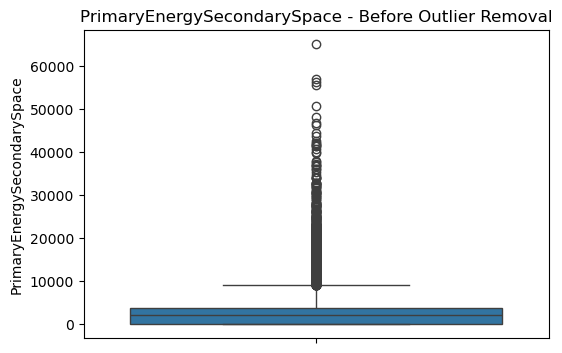

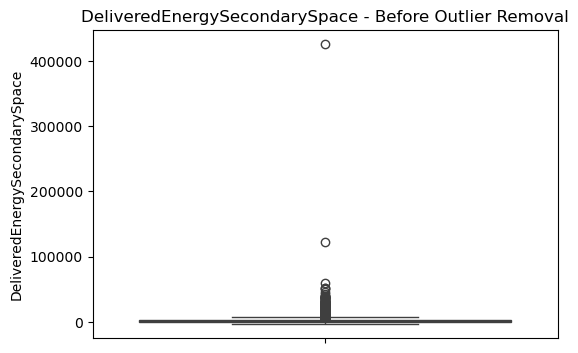

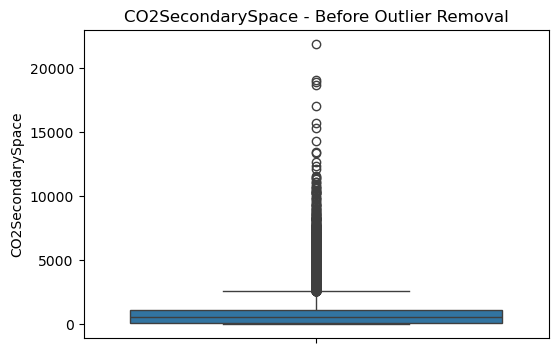

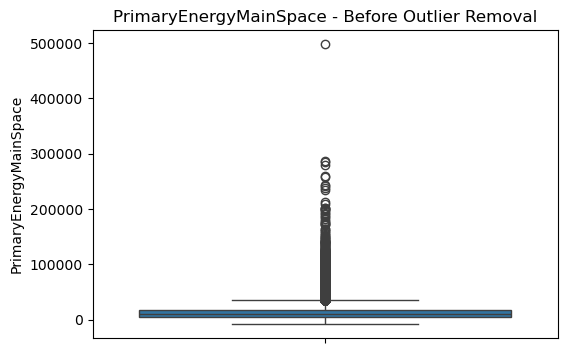

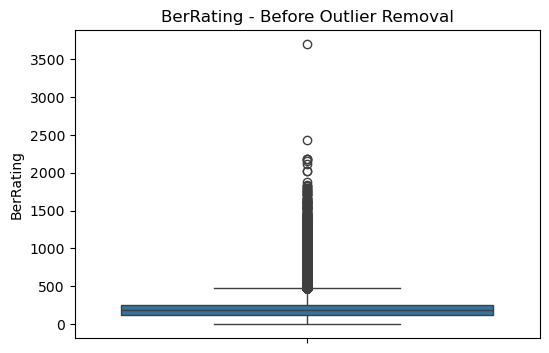

In [27]:
# plot before capping
for col in plot_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_sample[col], color=colors['numerical'])
    plt.title(f'{col} - Before Outlier Removal')
    plt.show()

In [28]:
# Cap extreme outliers by clipping numerical values to the 1st and 99th percentiles.
for col in num_cols:
    lower = df_sample[col].quantile(0.01)
    upper = df_sample[col].quantile(0.99)
    df_sample[col] = np.clip(df_sample[col], lower, upper)

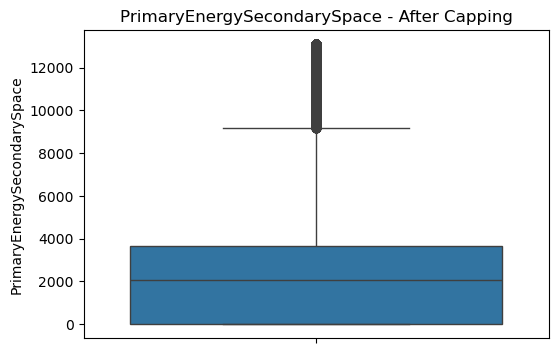

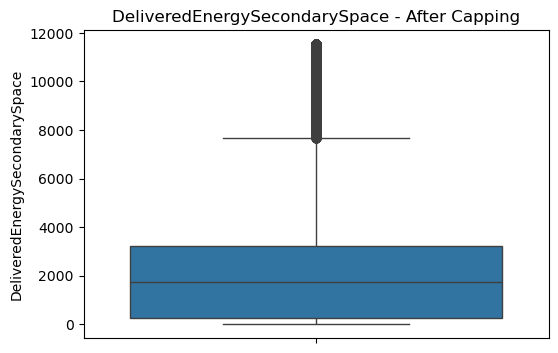

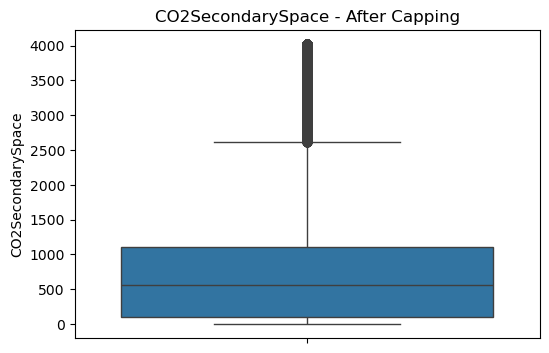

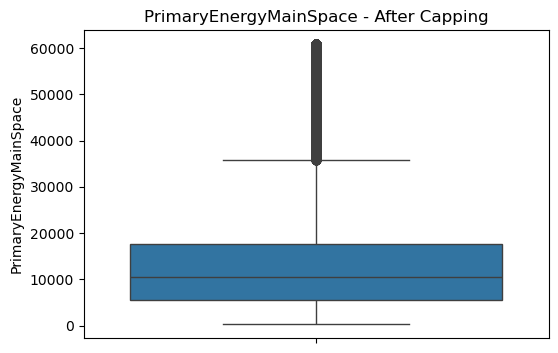

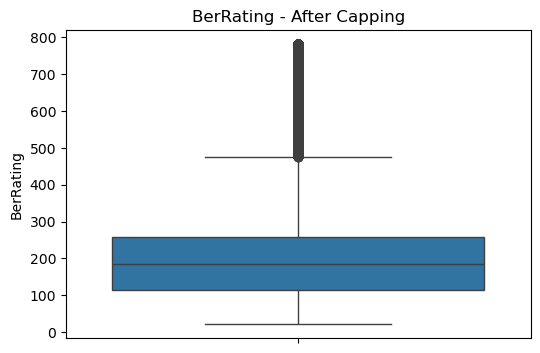

In [29]:
# Plot after capping
for col in plot_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df_sample[col], color=colors['numerical'], showfliers=True)
    plt.title(f'{col} - After Capping')
    plt.show()

### --- Removal of Low Variance Columns ---
Columns where almost all values are identical provide little to no information for predictive modeling and can increase computational overhead. Removing these low-variance features helps simplify the dataset without losing predictive power.

In [30]:
# Identify low variance columns
low_variance_cols = []
print("Low variance columns (value mostly constant):")
for col in df_sample.columns:
    top_freq = df_sample[col].value_counts(normalize=True, dropna=False).values[0]
    if top_freq > 0.90:  # Threshold - 90
        low_variance_cols.append(col)
        unique_count = df_sample[col].nunique(dropna=False)
        print(f"{col:<35} | Unique values: {unique_count:<5} | Top frequency: {top_freq:.2%}")

print(f"Total low variance columns: {len(low_variance_cols)}")

Low variance columns (value mostly constant):
MultiDwellingMPRN                   | Unique values: 2     | Top frequency: 99.27%
NoOfFluelessGasFires                | Unique values: 123   | Top frequency: 96.62%
HeatExchangerEff                    | Unique values: 548   | Top frequency: 92.21%
SuspendedWoodenFloor                | Unique values: 3     | Top frequency: 92.34%
OBBoilerThermostatControlled        | Unique values: 2     | Top frequency: 90.27%
OBPumpInsideDwelling                | Unique values: 2     | Top frequency: 92.58%
WarmAirHeatingSystem                | Unique values: 2     | Top frequency: 99.74%
UndergroundHeating                  | Unique values: 2     | Top frequency: 94.09%
GroundFloorUValue                   | Unique values: 229   | Top frequency: 94.12%
StorageLosses                       | Unique values: 2     | Top frequency: 97.03%
ManuLossFactorAvail                 | Unique values: 2     | Top frequency: 93.19%
SolarHotWaterHeating                | Uni

In [31]:
# Drop low variance columns
df_sample.drop(columns=low_variance_cols, inplace=True)
print("Dropped low variance columns")

Dropped low variance columns


In [32]:
print(f"AFTER DROPPING LOW VARIANCE COLUMNS --- Dataset shape: {df_sample.shape[0]} rows × {df_sample.shape[1]} columns")

AFTER DROPPING LOW VARIANCE COLUMNS --- Dataset shape: 80000 rows × 108 columns


### --- Data Type Optimization ---
Optimize the memory usage of the dataset by converting columns to more efficient data types without losing information. This is especially important for large datasets, as it improves performance and reduces computational load for subsequent feature selection and modeling steps.

In [33]:
# memory requirement before optimization
mem_before = df_sample.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage before optimization: {mem_before:.2f} MB")

Memory usage before optimization: 163.11 MB


In [34]:
conversions = []
# numeric columns
num_cols = df_sample.select_dtypes(include=['number']).columns.tolist()
for col in num_cols:
    old_dtype = df_sample[col].dtype
    if pd.api.types.is_float_dtype(df_sample[col]) and (df_sample[col] % 1 == 0).all():
        df_sample[col] = df_sample[col].astype('int32')
        conversions.append((col, old_dtype, 'int32'))
    elif pd.api.types.is_float_dtype(df_sample[col]):
        df_sample[col] = df_sample[col].astype('float32')
        conversions.append((col, old_dtype, 'float32'))
    elif pd.api.types.is_integer_dtype(df_sample[col]):
        df_sample[col] = df_sample[col].astype('int32')
        conversions.append((col, old_dtype, 'int32'))

In [35]:
#  categorical columns
cat_cols = df_sample.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    old_dtype = df_sample[col].dtype
    df_sample[col] = df_sample[col].astype('category')
    conversions.append((col, old_dtype, 'category'))

In [36]:
print("Columns converted (old_dtype → new_dtype):")
for col, old, new in conversions:
    print(f" - {col}: {old} → {new}")

Columns converted (old_dtype → new_dtype):
 - Year_of_Construction: float64 → int32
 - BerRating: float64 → float32
 - GroundFloorArea(sq m): float64 → float32
 - UValueWall: float64 → float32
 - UValueRoof: float64 → float32
 - UValueFloor: float64 → float32
 - UValueWindow: float64 → float32
 - UvalueDoor: float64 → float32
 - WallArea: float64 → float32
 - RoofArea: float64 → float32
 - FloorArea: float64 → float32
 - WindowArea: float64 → float32
 - DoorArea: float64 → float32
 - NoStoreys: float64 → int32
 - CO2Rating: float64 → float32
 - HSMainSystemEfficiency: float64 → float32
 - TGDLEdition: float64 → int32
 - MPCDERValue: float64 → float32
 - HSEffAdjFactor: float64 → float32
 - HSSupplHeatFraction: float64 → float32
 - HSSupplSystemEff: float64 → float32
 - WHMainSystemEff: float64 → float32
 - WHEffAdjFactor: float64 → float32
 - SupplSHFuel: float64 → float32
 - SupplWHFuel: float64 → float32
 - SHRenewableResources: float64 → float32
 - WHRenewableResources: float64 → fl

In [37]:
# memory requirement after optimization
mem_after = df_sample.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage after optimization: {mem_after:.2f} MB")
print(f"Total memory saved: {mem_before - mem_after:.2f} MB")


Memory usage after optimization: 33.63 MB
Total memory saved: 129.48 MB


### --- Removal of Leakage Columns ---

Certain columns in the BER dataset is directly calculated from the target BerRating
These columns must be removed before feature engineering and modeling to avoid data leakage

In [38]:
# Identify features
feature_list = df_sample.columns.tolist()

In [39]:
print(feature_list)

['CountyName', 'DwellingTypeDescr', 'Year_of_Construction', 'TypeofRating', 'EnergyRating', 'BerRating', 'GroundFloorArea(sq m)', 'UValueWall', 'UValueRoof', 'UValueFloor', 'UValueWindow', 'UvalueDoor', 'WallArea', 'RoofArea', 'FloorArea', 'WindowArea', 'DoorArea', 'NoStoreys', 'CO2Rating', 'MainSpaceHeatingFuel', 'MainWaterHeatingFuel', 'HSMainSystemEfficiency', 'TGDLEdition', 'MPCDERValue', 'HSEffAdjFactor', 'HSSupplHeatFraction', 'HSSupplSystemEff', 'WHMainSystemEff', 'WHEffAdjFactor', 'SupplSHFuel', 'SupplWHFuel', 'SHRenewableResources', 'WHRenewableResources', 'NoOfChimneys', 'NoOfOpenFlues', 'NoOfFansAndVents', 'DraftLobby', 'VentilationMethod', 'FanPowerManuDeclaredValue', 'StructureType', 'PercentageDraughtStripped', 'NoOfSidesSheltered', 'PermeabilityTest', 'PermeabilityTestResult', 'TempAdjustment', 'HeatSystemControlCat', 'HeatSystemResponseCat', 'NoCentralHeatingPumps', 'CHBoilerThermostatControlled', 'NoOilBoilerHeatingPumps', 'NoGasBoilerHeatingPumps', 'DistributionLosses

In [40]:
# leakage columns (they won't be used in upcoming feature selection)
leakage_columns = [
    'CO2Rating',      # CO2 rating: calculated from building energy performance, indirectly dependent on BER (leakage)
    'CPC',            # Calculated Performance Certificate - derived from BER and other efficiency parameters (leakage)
    'EPC',             # Energy Performance Certificate: derived from BER and other efficiency parameters (leakage)
    'BER_bin'         # Introduced during sampling step
]

df_sample = df_sample.drop(columns=[c for c in leakage_columns if c in df_sample.columns])

### --- Removal of High-Cardinality Categorical Columns ---

Some categorical columns in the BER dataset have nearly unique values for each row (e.g., addresses, IDs, or long descriptions). These columns provide little predictive value and act like identifiers rather than meaningful features.

In [43]:
threshold = 0.01  

high_cardinality_cols = [
    col for col in df_sample.select_dtypes(include=['object', 'category']).columns
    if df_sample[col].nunique() / len(df_sample) > threshold
]

print("High-cardinality categorical columns:")
print(high_cardinality_cols)

High-cardinality categorical columns:
['DateOfAssessment', 'FirstWallDescription', 'SA_Code']


In [44]:
df_sample = df_sample.drop(columns=high_cardinality_cols)

### --- Shuffle Dataset ---
Randomly shuffle the dataset to ensure that the order of rows does not introduce any bias in subsequent steps like feature selection or modeling.

In [45]:
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset shuffled successfully. Total records:", len(df_sample))

Dataset shuffled successfully. Total records: 80000


### Saving the cleaned dataset

In [46]:
file_path = r"..\dataset\BERPublicsearch_Cleaned.csv"
df_sample.to_csv(file_path, index=False)
print(f"Cleaned dataset saved successfully")

Cleaned dataset saved successfully


In [47]:
print(f"After cleaning - Dataset shape: {df_sample.shape[0]} rows × {df_sample.shape[1]} columns")

After cleaning - Dataset shape: 80000 rows × 101 columns


### Dataset Overview

- **Raw Dataset:** 1,048,575 rows × 211 columns. Contains missing values, duplicates, low-variance features, and inconsistent data types.  
- **Cleaned Dataset:** 80,000 rows × 101 columns. Cleaned by handling missing values, capping outliers, removing low-variance columns, optimizing data types, and shuffling. Ready for feature selection and modeling.
